<a href="https://colab.research.google.com/github/jcterrero02/CoderHouse/blob/main/Machine%20Learning%20para%20la%20Ciencia%20de%20Datos/Coder_II_Credit_Card_Elegibility_Julio_Terrero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install boruta
%pip install scikit-optimize

# Importamos Paquetes



In [1]:
# Importamos las librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import get_scorer, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, PrecisionRecallCurve, ClassificationReport
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from boruta import BorutaPy
from skopt import BayesSearchCV, space, plots
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve

# Carga de Datos

In [2]:
# Url del dataset hosteado en Github, con informacion sobre aprobaciones de tarjetas de credito
url = 'https://raw.githubusercontent.com/jcterrero02/CoderHouse/main/Fundamentos%20para%20la%20Ciencia%20de%20Datos/data/credit_card_elegibilty.csv'

dataset = pd.read_csv(url, delimiter=',')

# Descripcion de Dataset

Variable	Description
*  **ID**	An identifier for each individual (customer).
* **Gender**	The gender of the individual.
* **Own_car**	A binary feature indicating whether the individual owns a car.
* **Own_property**	A binary feature indicating whether the individual owns a property.
* **Work_phone**	A binary feature indicating whether the individual has a work phone.
* **Phone**	A binary feature indicating whether the individual has a phone.
* **Email**	A binary feature indicating whether the individual has provided an email address.
* **Unemployed**	A binary feature indicating whether the individual is unemployed.
* **Num_children**	The number of children the individual has.
* **Num_family**	The total number of family members.
* **Account_length**	The length of the individual's account with a bank or financial institution.
* **Total_income**	The total income of the individual.
* **Age**	The age of the individual.
* **Years_employed**	The number of years the individual has been employed.
* **Income_type**	The type of income (e.g., employed, self-employed, etc.).
* **Education_type**	The education level of the individual.
* **Family_status**	The family status of the individual.
* **Housing_type**	The type of housing the individual lives in.
* **Occupation_type**	The type of occupation the individual is engaged in.
* **Target**	The target variable for the classification task, indicating whether the individual is eligible for a credit card or not (e.g., Yes/No, 1/0).

**Preguntas a responder sobre el dataset**
1. Existe una relación entre la edad y la aprobación de una tarjeta de crédito?
2. Los aplicantes con ingresos más altos tienen probabilidad más alta de aprobación de una tarjeta de crédito?
3. La cantidad de dependientes afecta la probabilidad de aprobación de una tarjeta de crédito?
4. Existe una diferencia significativa entre la elegibilidad de la tarjeta dependiendo el género del solicitante?
5. El tipo de trabajo influye en la elegibilidad?

# Analisis Exploratorio

In [3]:
# Visualizacion de las primeras 5 filas del dataset
dataset.head(5)

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int64  
 1   Gender           9709 non-null   int64  
 2   Own_car          9709 non-null   int64  
 3   Own_property     9709 non-null   int64  
 4   Work_phone       9709 non-null   int64  
 5   Phone            9709 non-null   int64  
 6   Email            9709 non-null   int64  
 7   Unemployed       9709 non-null   int64  
 8   Num_children     9709 non-null   int64  
 9   Num_family       9709 non-null   int64  
 10  Account_length   9709 non-null   int64  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_type   9709 non-null   object 
 16  Family_status    9709 non-null   object 
 17  Housing_type  

In [5]:
dataset.isnull().sum()

,0
ID,0
Gender,0
Own_car,0
Own_property,0
Work_phone,0
Phone,0
Email,0
Unemployed,0
Num_children,0
Num_family,0


No existen valores nulos dentro del dataset

In [6]:
# Descripcion de Variable Objetivo/Dependiente
dataset['Target'].describe()

,Target
count,9709.000000
mean,0.132145
std,0.338666
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [7]:
dataset['Target'].value_counts()

,count
Target,
0,8426
1,1283


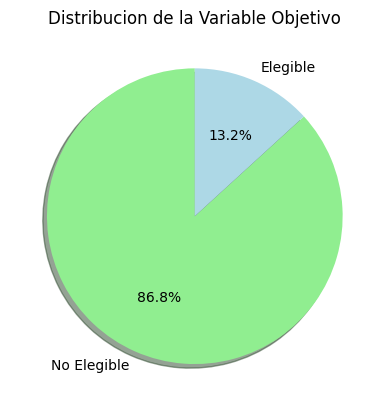

In [8]:
# Conteo de la variable objetivo
target_counts = dataset['Target'].value_counts()

labels = ['No Elegible', 'Elegible']
colors = ['lightgreen', 'lightblue']

plt.pie(target_counts, labels=labels, autopct='%1.1f%%', colors=colors, shadow=True, startangle=90)
plt.title('Distribucion de la Variable Objetivo')
plt.show()


Se evidencia que tenemos un dataset desbalanceado

<Axes: xlabel='Target', ylabel='Total_income'>

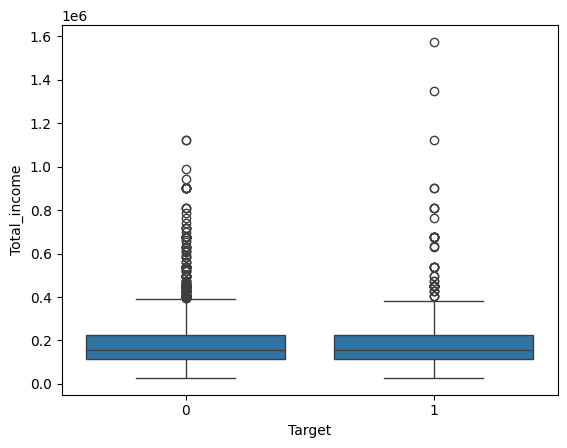

In [9]:
# Veamos la distribucion de los ingresos comparado con la variable objetivo
sns.boxplot(data=dataset, y= 'Total_income', x="Target")


In [10]:
income_pivot = dataset.pivot_table(values='Total_income', index='Target', aggfunc='mean')
print(income_pivot)

         Total_income
Target               
0       180500.539817
1       186007.008963


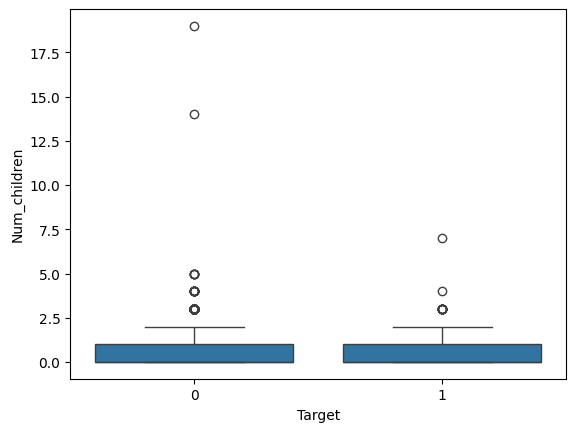

In [11]:
# Verifiquemos si la cantidad de hijos afecta la elegibilidad de la tarjeta de crédito

sns.boxplot(data=dataset, y= 'Num_children', x="Target")
plt.show()

Aparte de algunos valores atipicos no aparenta ver relación negativa entre la cantidad de hijos y la aprobación de la tarjeta de crédito

## Analisis bivariado de los datos

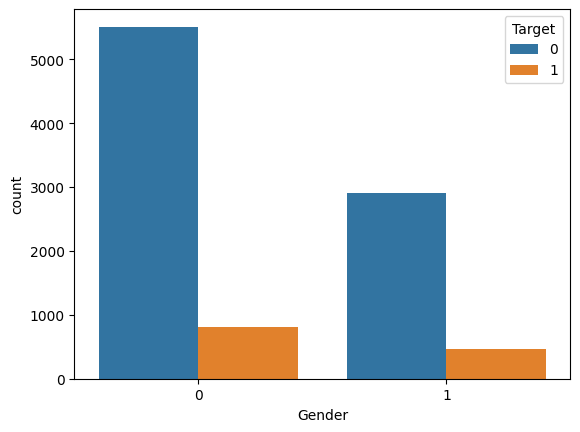

In [12]:
# Verifiquemos si el sexo afecta la variable objetivo
sns.countplot(x = 'Gender', hue = 'Target', data = dataset)
plt.show()


La diferencia entre las personas que reciben una tarjeta y las que no, a nivel de ingresos totales no aparenta ser tan significativa

<Axes: xlabel='Target', ylabel='Age'>

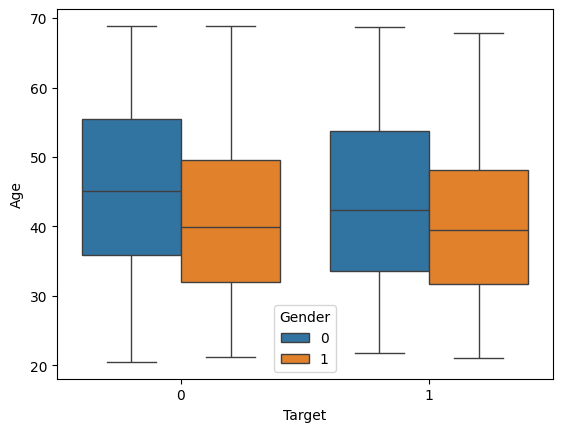

In [13]:
sns.boxplot(x = "Target", y = "Age", hue='Gender', data = dataset)

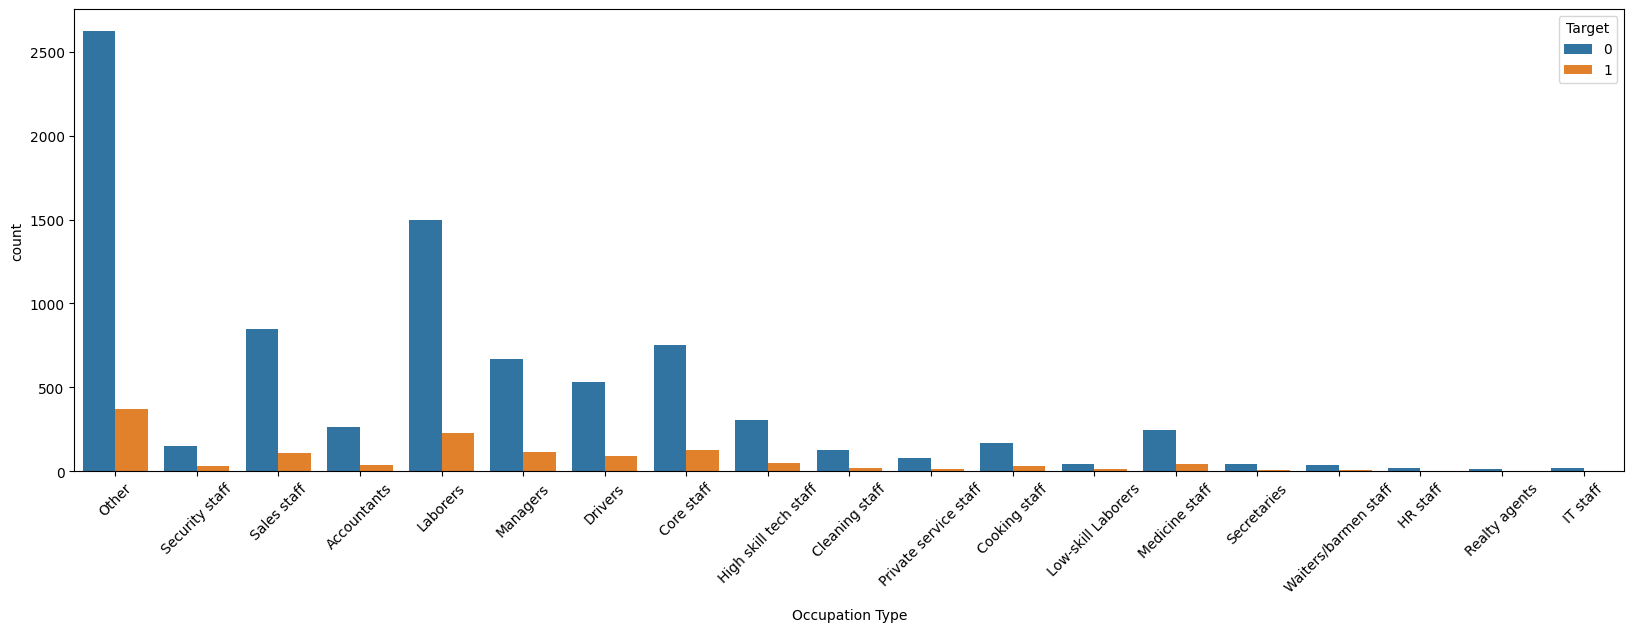

In [14]:
# Analizar si el tipo de ocupación afecta la variable objetivo
plt.figure(figsize=(20, 6))

sns.countplot(x = "Occupation_type", hue = "Target", data = dataset)
plt.xlabel("Occupation Type", labelpad=10.0)
plt.xticks(rotation=45)
plt.show()

La ocupación "Laborers" aparenta tener alta incidencia en la no aprobación del crédito

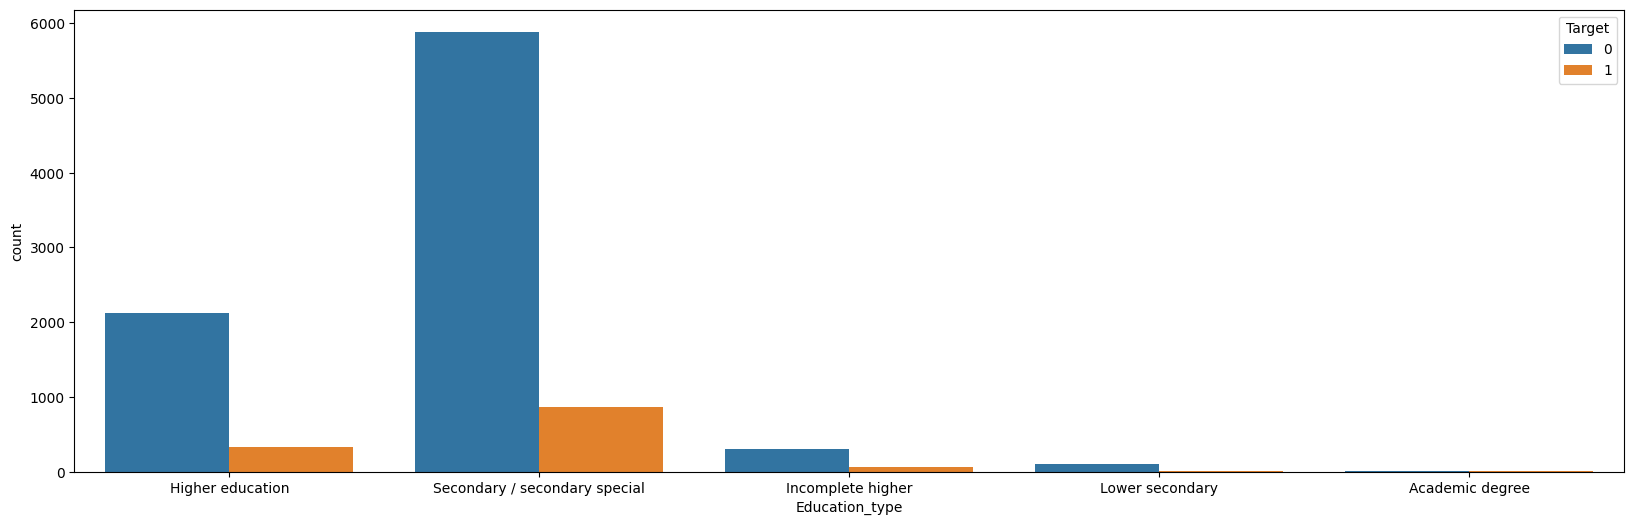

In [15]:
# Verifiquemos si el sexo afecta la variable objetivo
plt.figure(figsize=(20, 6))

sns.countplot(x = 'Education_type', hue = 'Target', data = dataset)
plt.show()

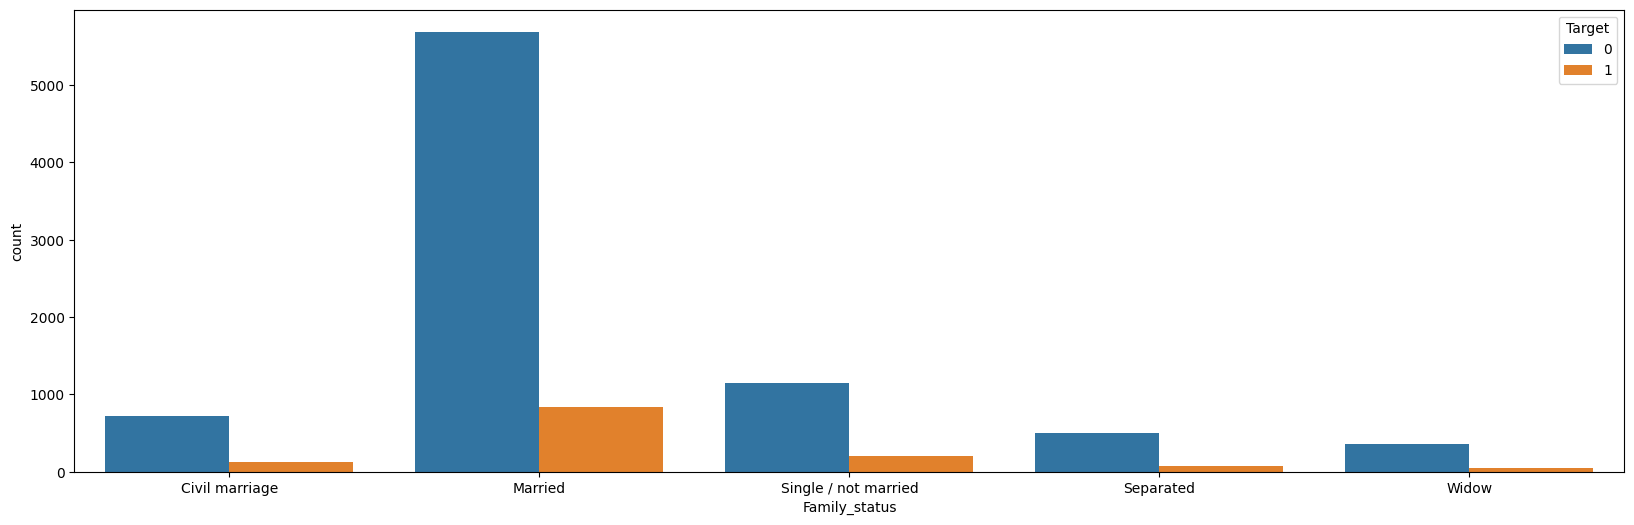

In [16]:
# Verifiquemos si el sexo afecta la variable objetivo
plt.figure(figsize=(20, 6))

sns.countplot(x = 'Family_status', hue = 'Target', data = dataset)
plt.show()

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int64  
 1   Gender           9709 non-null   int64  
 2   Own_car          9709 non-null   int64  
 3   Own_property     9709 non-null   int64  
 4   Work_phone       9709 non-null   int64  
 5   Phone            9709 non-null   int64  
 6   Email            9709 non-null   int64  
 7   Unemployed       9709 non-null   int64  
 8   Num_children     9709 non-null   int64  
 9   Num_family       9709 non-null   int64  
 10  Account_length   9709 non-null   int64  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_type   9709 non-null   object 
 16  Family_status    9709 non-null   object 
 17  Housing_type  

In [18]:
dataset.select_dtypes(include=['object'])

,Income_type,Education_type,Family_status,Housing_type,Occupation_type
0,Working,Higher education,Civil marriage,Rented apartment,Other
1,Working,Secondary / secondary special,Married,House / apartment,Security staff
2,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
3,Pensioner,Higher education,Separated,House / apartment,Other
4,Working,Higher education,Married,House / apartment,Accountants
...,...,...,...,...,...
9704,Pensioner,Secondary / secondary special,Civil marriage,Municipal apartment,Laborers
9705,Commercial associate,Secondary / secondary special,Married,House / apartment,Other
9706,Working,Secondary / secondary special,Married,House / apartment,Other
9707,Pensioner,Higher education,Married,House / apartment,Medicine staff


Text(70.7222222222222, 0.5, 'Housing_type')

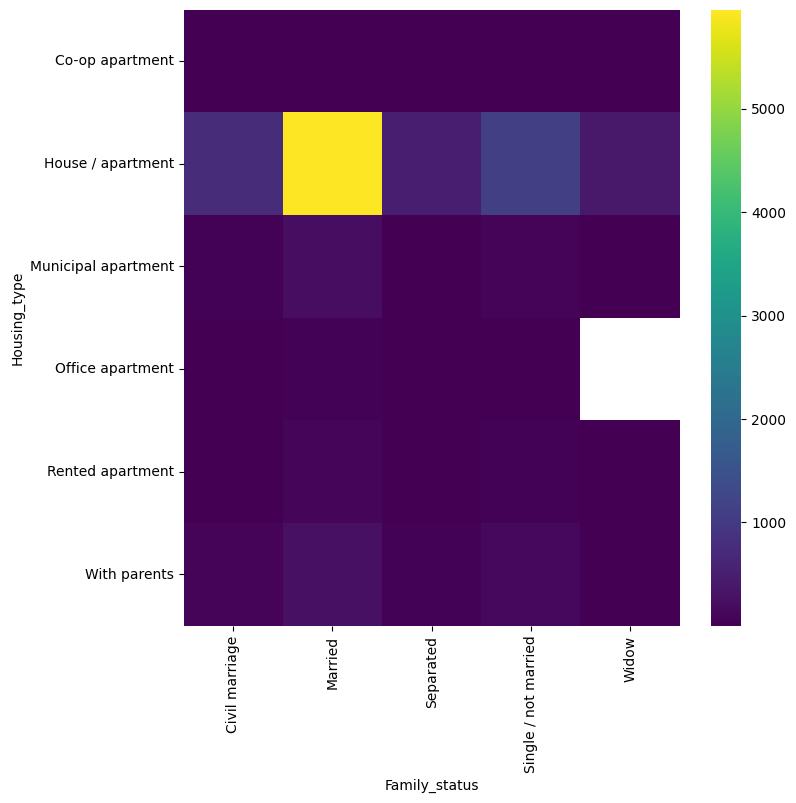

In [19]:
# Analisis bivariado de Family_status y Housing_type

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Housing_type'].value_counts()
    for x_label, grp in dataset.groupby('Family_status')
})

sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Family_status')
plt.ylabel('Housing_type')

Text(70.7222222222222, 0.5, 'Family_status')

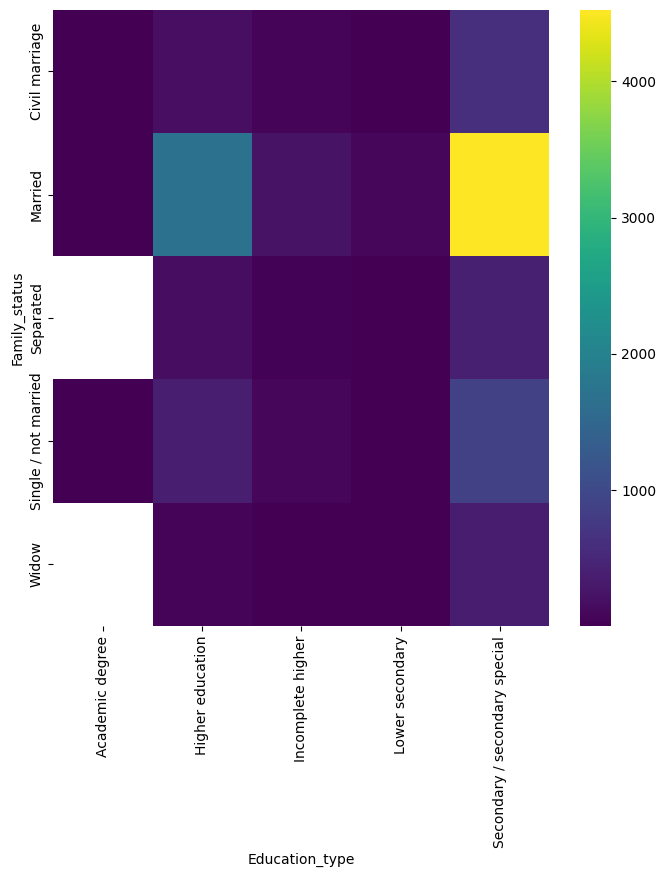

In [20]:
# Analisis bivariado de Family_status y Education_type

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Family_status'].value_counts()
    for x_label, grp in dataset.groupby('Education_type')
})

sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Education_type')
plt.ylabel('Family_status')

Se evidencia que la mayoria de aplicantes estan casados y con una educacion secundaria

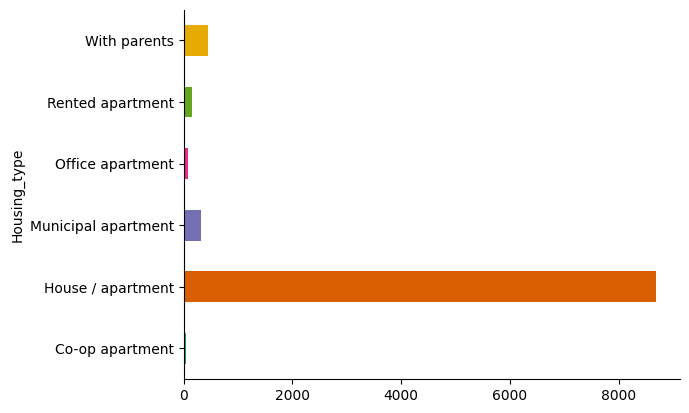

In [21]:
dataset.groupby('Housing_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

la mayoria de los aplicantes estan poseen House / apartment, podemos convertir esta variable en una dummies

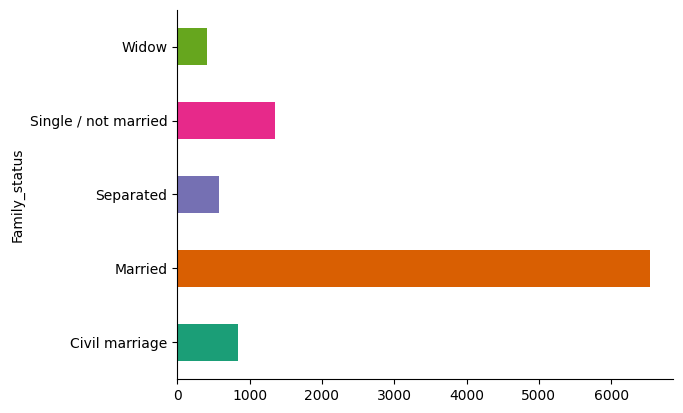

In [22]:
dataset.groupby('Family_status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

la mayoria de los aplicantes estan casados, podemos convertir esta variable en una dummies

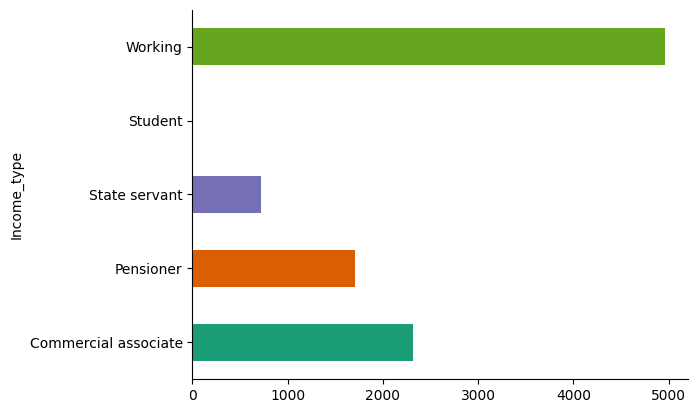

In [23]:
dataset.groupby('Income_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

plt.gca().spines[['top', 'right',]].set_visible(False)

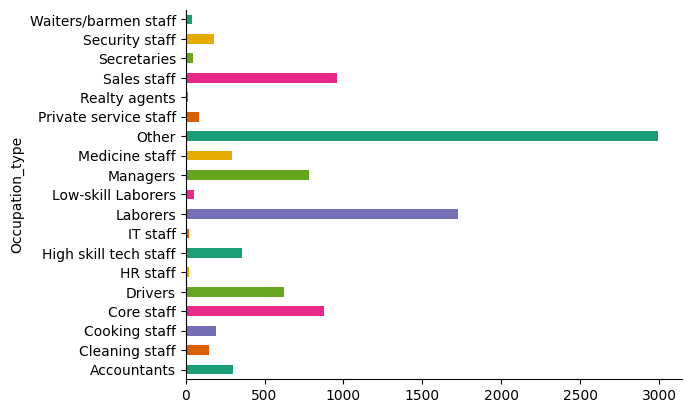

In [24]:
dataset.groupby('Occupation_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

plt.gca().spines[['top', 'right',]].set_visible(False)

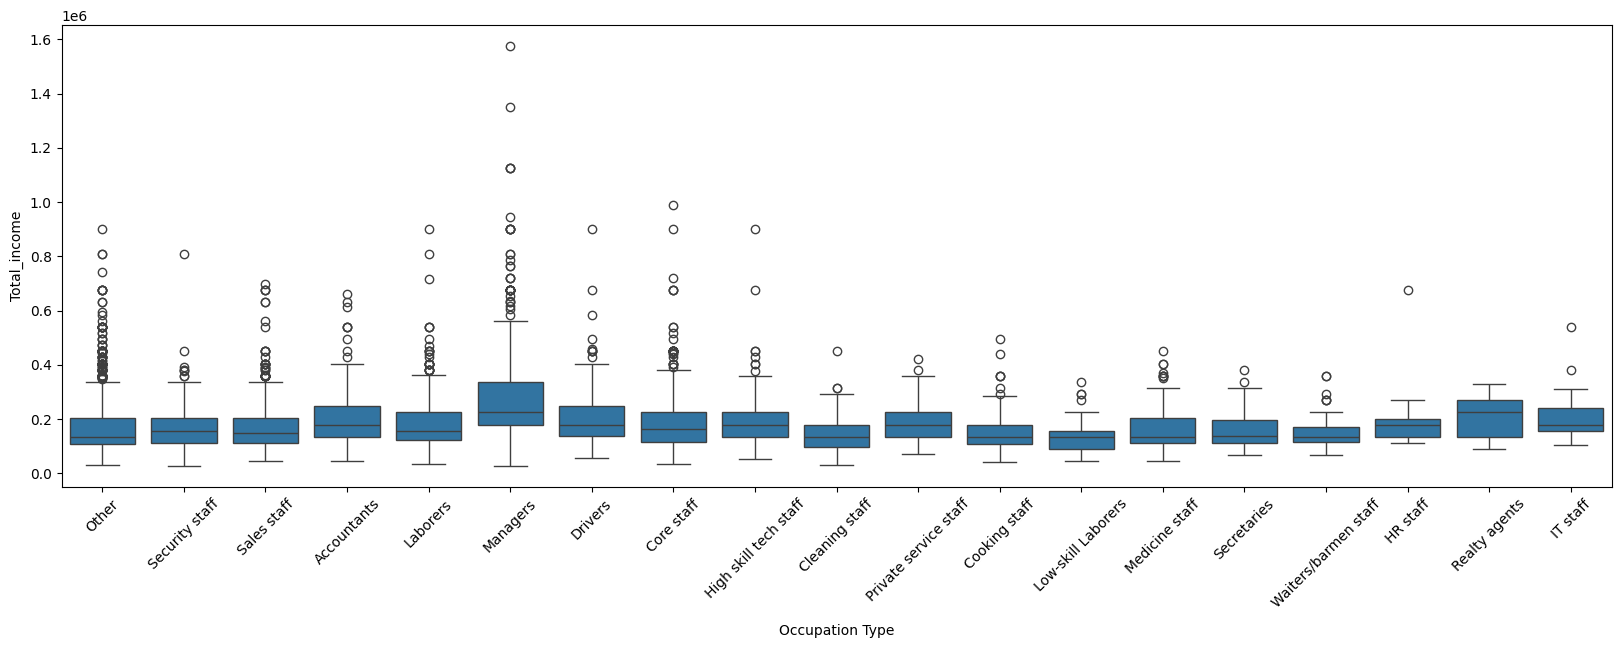

In [25]:
# Verifiquemos los ingresos basados en el tipo de ocupacion
plt.figure(figsize=(20, 6))
sns.boxplot(data=dataset, x= 'Occupation_type', y="Total_income")
plt.xlabel("Occupation Type", labelpad=10.0)
plt.xticks(rotation=45)
plt.show()

Correlación de las variables

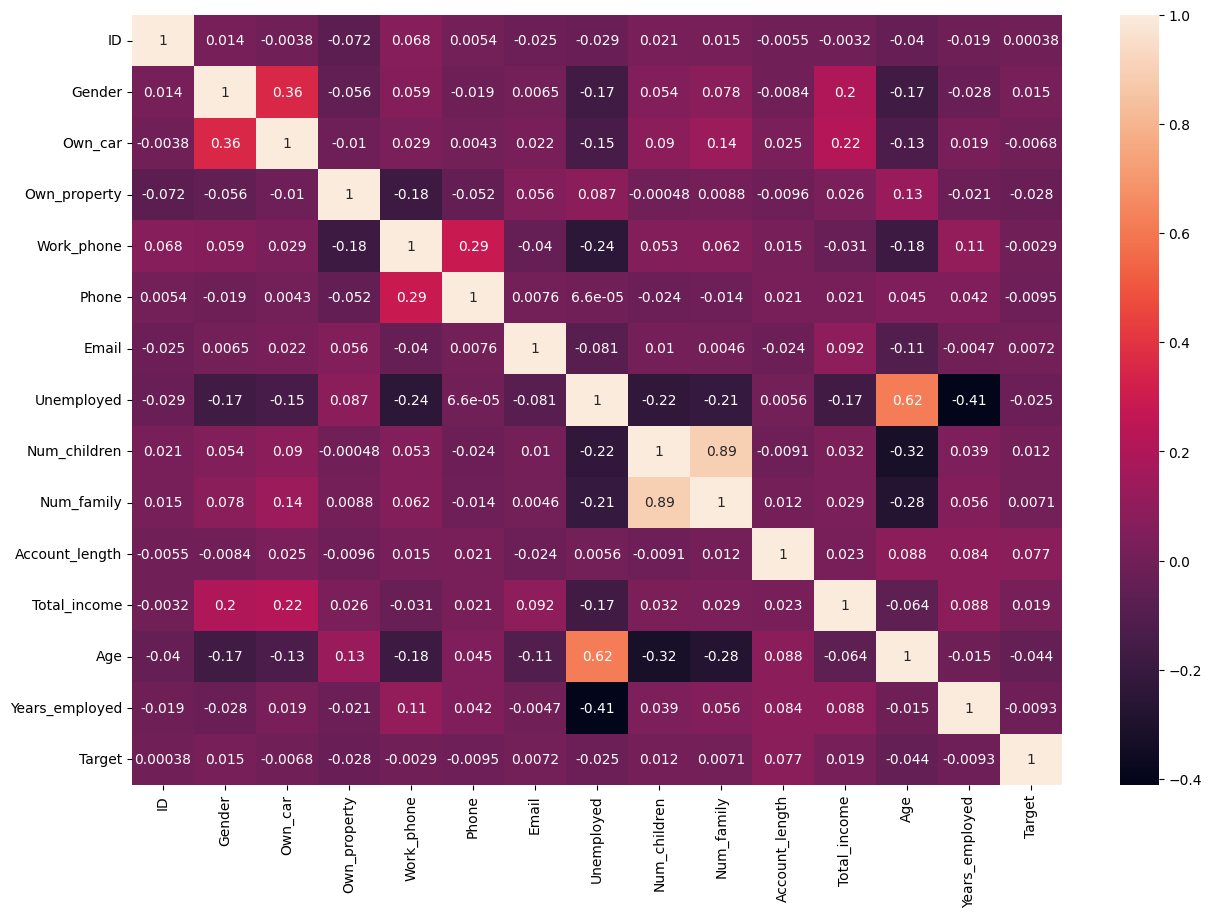

In [28]:
# Para poder predecir debemos evaluar la correlación, entre variables predictoras y entre variables predictoras con la variable objetivo
plt.figure(figsize = (15, 10))

correlation_matrix = dataset.select_dtypes(include=['int64', 'float64']).corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

# Insigths


Resultados del analisis de correlación


*  Las variables Num_family and Num_children poseen alta correlacion positiva, podemos eliminar la variable Num_family ya que posee una correlacion mas baja con la variable objetivo
*   Las variables Gender y Own_car poseen una correlación alta con respecto a las demas variables, tomando en cuenta que la variable Own_car posee una correlación negativa con la variable objetivo podemos disponer de ella
*   Las variables Unemployed y Years_employed poseen alta correlacion negativa, tomando en cuenta que la variable Unemployed tambien posee alta correlacion positiva con Age, podemos eliminar la variable Unemployed



**Respuestas a preguntas:**

1.   La edad, el tamaño de la familia, el genero, el tipo de trabajo y los ingresos totales de los aplicantes no aparentan ser factores determinantes fuertes para la aprobación de las tarjetas de credito



# Preprocessing

In [32]:
X = dataset.drop(columns={'ID', 'Phone', 'Work_phone', 'Unemployed', 'Own_car', 'Num_children', 'Email', 'Target'}, axis=1)
y = dataset['Target']

In [55]:
for col in X.columns:
  if X[col].dtypes in ['object', 'category']:
      X[col] = X[col].fillna('None')
  elif X[col].dtypes in ['int', 'float', 'float32', 'float64', 'int32', 'int64']:
      X[col] = X[col].fillna(0)
  elif X[col].dtypes in ['date']:
      print(f"Columna {col} es de tipo fecha. Se eliminará.")
      X = X.drop(columns = col)

# Divida el conjunto de datos en conjuntos de entrenamiento y prueba, y el 25 % de los datos se utilizará para las pruebas.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Inicializar StandardScaler y OneHotEncoder
scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

cat_selector = make_column_selector(dtype_include=['object', 'category'])
num_selector = make_column_selector(dtype_include='number')

# Tuplas para aplicar las transformaciones a columnas numéricas y categóricas
num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)

# Transformador de columna para aplicar las transformaciones especificadas.
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
col_transformer.fit(X_train)

# Ajustar el escalador y el codificador a los datos de entrenamiento
scaler.fit(X_train[num_selector])
ohe.fit(X_train[cat_selector])

# Extrae los nombres de las columnas para las características numéricas
num_cols = X_train[num_selector].columns

# Generar nuevos nombres de columnas después de las transformaciones
variables = []
for x in list(col_transformer.get_feature_names_out()):
    x_ = x.replace('standardscaler__', '').replace('onehotencoder__', '').replace('remainder__', '').replace('(', '').replace(']', '').replace(',', '_')
    variables.append(x_)

# Transformar los datos de entrenamiento y prueba.
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

# Convertir los datos procesados nuevamente a marcos de datos con nuevos nombres de columna
X_train_df = pd.DataFrame(X_train_processed, columns=variables, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=variables, index=X_test.index)

# Identificar columnas categóricas en los datos transformados
cat_cols = [col for col in X_train_df.columns if col not in num_cols]

In [56]:
for col in X_train_df.columns:
    if X_train_df[col].dtype=="object" or X_train_df[col].dtype == "category":
          pass
    else:
        lower_percentile = 0.05
        upper_percentile = 1 - lower_percentile
        lower_bound = X_train_df[col].quantile(lower_percentile)
        upper_bound = X_train_df[col].quantile(upper_percentile)
        X_train_df[col] = np.where(X_train_df[col] < lower_bound, lower_bound, X_train_df[col])
        X_train_df[col] = np.where(X_train_df[col] > upper_bound, upper_bound, X_train_df[col])
        X_test_df[col] = np.where(X_test_df[col] < lower_bound, lower_bound, X_test_df[col])
        X_test_df[col] = np.where(X_test_df[col] > upper_bound, upper_bound, X_test_df[col])

In [57]:
X_test_df.head()

,Gender,Own_property,Num_family,Account_length,Total_income,Age,Years_employed,Income_type_Commercial associate,Income_type_Pensioner,Income_type_State servant,...,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Other,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff
6416,-0.730402,-1.418156,0.901787,-0.727815,-0.987408,-1.476018,-0.796644,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2144,-0.730402,0.705141,-0.188896,-1.451893,-0.676428,-0.547661,-0.348068,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239,1.369108,-1.418156,-0.188896,0.599660,0.656348,0.184250,1.954017,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6395,-0.730402,-1.418156,1.992469,0.599660,-1.031834,-0.176412,0.517969,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
355,1.369108,0.705141,0.901787,1.746117,1.766993,0.507975,-0.597853,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Reduccion Dimensionalidad

In [60]:
weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
model = XGBClassifier(scale_pos_weight=weight)
boruta_selector = BorutaPy(estimator=model, n_estimators='auto', random_state=42, verbose=2, max_iter=30, perc=0.8)

# Fit Boruta
boruta_selector.fit(np.array(X_train_df), np.array(y_train))

# Get selected features
selected_features = X_train_df.columns[boruta_selector.support_]
print(f"Selected features: {selected_features}")

# Transform data using selected features
X_train_boruta = boruta_selector.transform(np.array(X_train_df))
X_test_boruta = boruta_selector.transform(np.array(X_test_df))

# Convert transformed data back to dataframes
X_train_boruta = pd.DataFrame(X_train_boruta, columns=selected_features, index = X_train_df.index)
X_test_boruta = pd.DataFrame(X_test_boruta, columns=selected_features, index = X_test_df.index)

Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	47
Rejected: 	0
Iteration: 	8 / 30
Confirmed: 	24
Tentative: 	0
Rejected: 	23


BorutaPy finished running.

Iteration: 	9 / 30
Confirmed: 	24
Tentative: 	0
Rejected: 	23
Selected features: Index(['Gender', 'Own_property', 'Num_family', 'Account_length',
       'Total_income', 'Age', 'Years_employed',
       'Income_type_Commercial associate', 'Income_type_Pensioner',
       'Income_type_State servant', 'Income_type_Working',
       'Education_type_Higher education',
       'Education_type_Secondary / secondary special',
       'Family_status_Civil marriage', 'Family_status_Married',

# Training

In [61]:
lgbm_cl = lgb.LGBMClassifier()

# Definir los parámetros de búsqueda
param_grid = {'n_estimators': Integer(100, 250),
              'is_unbalance': Categorical([True]),
              'colsample_bytree': Real(0.1, 0.7),
              'learning_rate': Real(0.01, 0.5),
              'max_depth': Integer(6, 15)}

lgb_optimizador = BayesSearchCV(lgbm_cl,
                            search_spaces = param_grid,
                            cv=3,
                            scoring="roc_auc",
                            n_jobs= 4,
                            verbose = 1,
                            n_iter=10)

lgb_optimizador.fit(X_train_boruta, y_train)

lgbm_best_model = lgb_optimizador.best_estimator_

# Best score
lgb_optimizador.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 962, number of negative: 6319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 7281, num

0.5656623873885634

In [62]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_cl = XGBClassifier(scale_pos_weight=scale_pos_weight)

# Definir los parámetros de búsqueda
param_grid = {'colsample_bytree': Real(0.3, 0.8),
                  'learning_rate': Real(0.001, 0.1),
                  'max_depth': Integer(5, 25),
                  'gamma': Real(5, 25)}

xgb_optimizador = BayesSearchCV(xgb_cl,
                            search_spaces = param_grid,
                            cv=3,
                            scoring="roc_auc",
                            n_jobs= 4,
                            verbose = 1,
                            n_iter=10)

xgb_optimizador.fit(X_train_boruta, y_train)

xgb_best_model = xgb_optimizador.best_estimator_

# Best score
xgb_optimizador.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


0.586394636462233

In [63]:
rf_cl = RandomForestClassifier()

# Definir los parámetros de búsqueda
param_grid = {'criterion': Categorical(['gini', 'entropy']),
                         'class_weight': Categorical(['balanced']),
                         'n_estimators': Integer(20, 200),
                         'max_depth': Integer(6, 18)}

rf_optimizador = BayesSearchCV(rf_cl,
                      search_spaces = param_grid,
                      cv=3,
                      scoring="roc_auc",
                      n_jobs= 4,
                      verbose = 1,
                      n_iter=10)

rf_optimizador.fit(X_train_boruta, y_train)

rf_best_model = rf_optimizador.best_estimator_

# Best score
rf_optimizador.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


0.5756307126862553

# Evaluacion de Estimadores

In [65]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

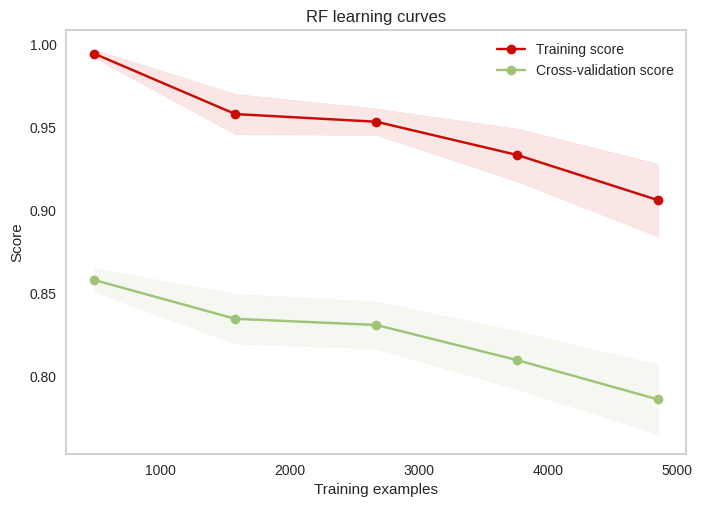

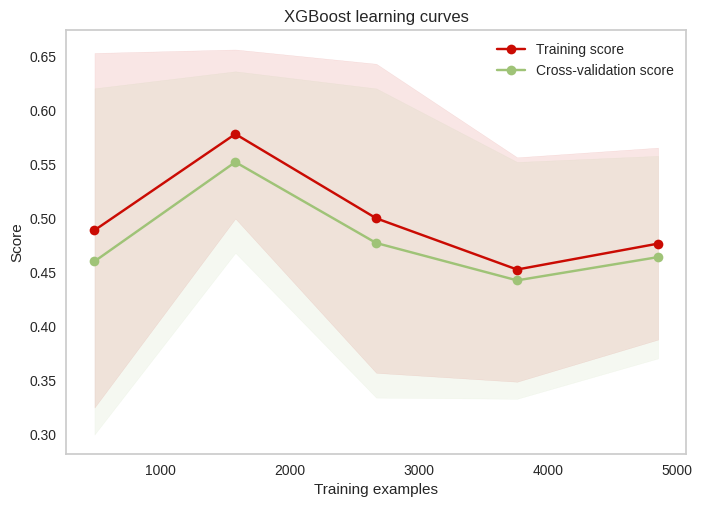

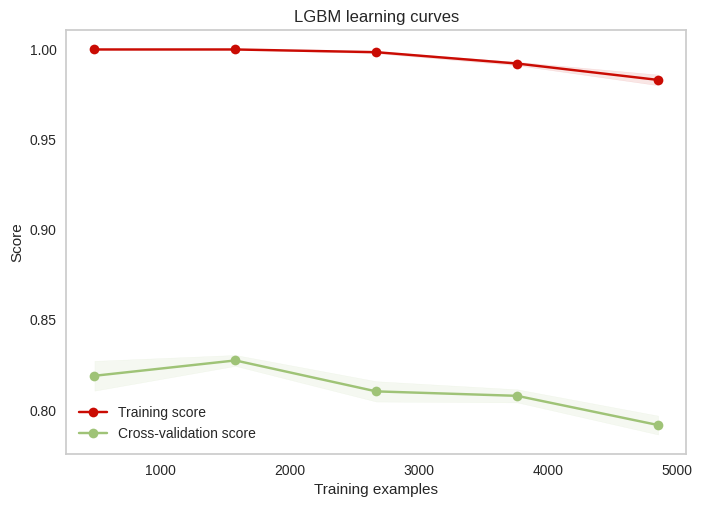

In [66]:
g = plot_learning_curve(rf_best_model,"RF learning curves", X_train_boruta, y_train, cv=3)
g = plot_learning_curve(xgb_best_model,"XGBoost learning curves", X_train_boruta, y_train, cv=3)
g = plot_learning_curve(lgbm_best_model,"LGBM learning curves", X_train_boruta,y_train, cv=3)

## XGBoost

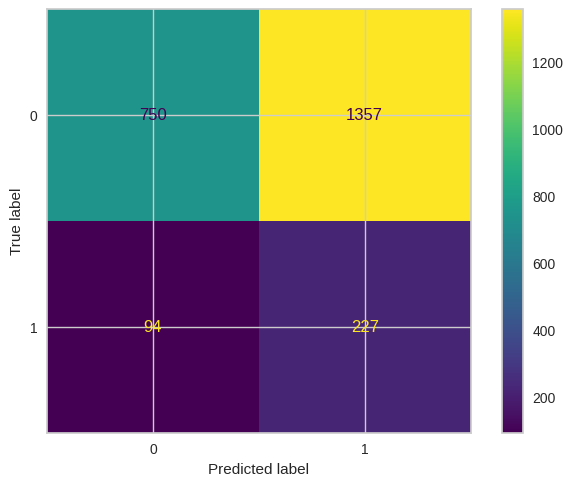

              precision    recall  f1-score   support

           0       0.89      0.36      0.51      2107
           1       0.14      0.71      0.24       321

    accuracy                           0.40      2428
   macro avg       0.52      0.53      0.37      2428
weighted avg       0.79      0.40      0.47      2428



In [68]:
# Hacer predicciones
y_pred_test = xgb_best_model.predict(X_test_boruta)

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix= cm,
                              display_labels= xgb_best_model.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred_test))

## LigthGBM

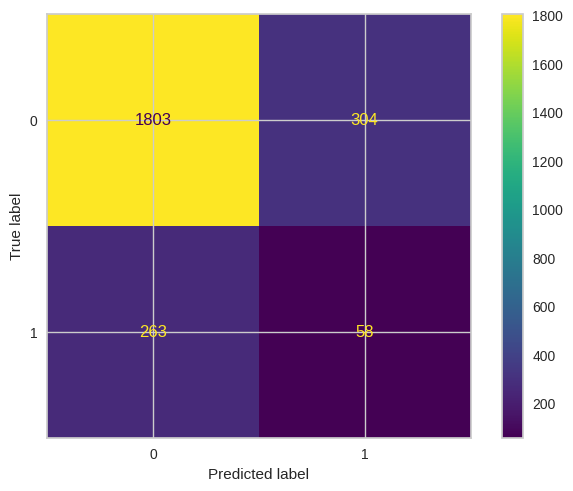

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2107
           1       0.16      0.18      0.17       321

    accuracy                           0.77      2428
   macro avg       0.52      0.52      0.52      2428
weighted avg       0.78      0.77      0.77      2428



In [69]:
# Hacer predicciones
y_pred_test = lgbm_best_model.predict(X_test_boruta)

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix= cm,
                              display_labels= lgbm_best_model.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred_test))

## RandomForest

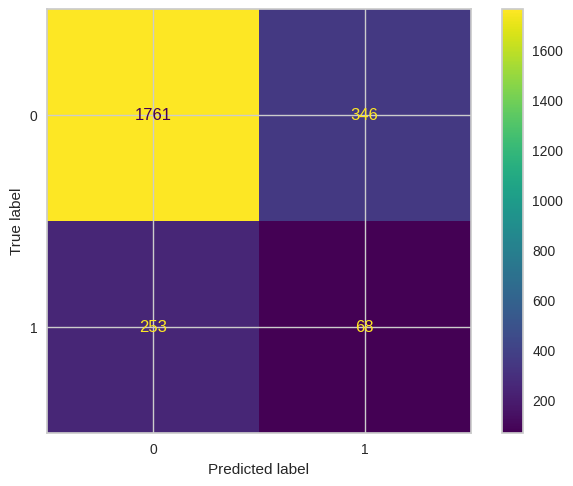

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      2107
           1       0.16      0.21      0.19       321

    accuracy                           0.75      2428
   macro avg       0.52      0.52      0.52      2428
weighted avg       0.78      0.75      0.77      2428



In [70]:
# Hacer predicciones
y_pred_test = rf_best_model.predict(X_test_boruta)

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix= cm,
                              display_labels= lgbm_best_model.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred_test))

## Feature Importance

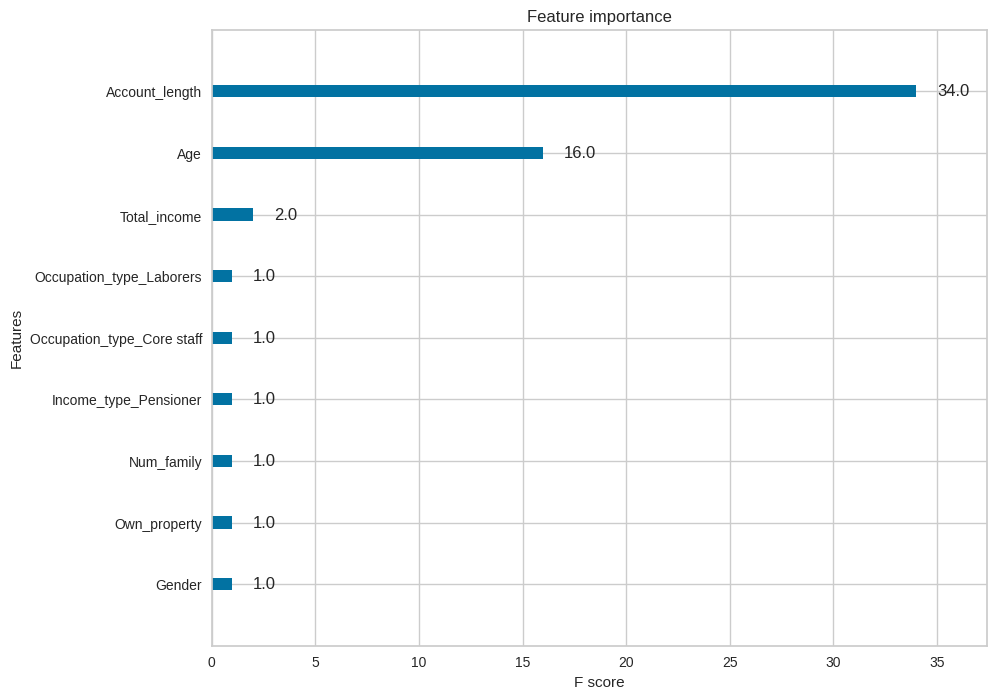

In [71]:
from xgboost import plot_importance

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_best_model, ax=ax)
plt.show()

# Conclusión

En base a las metricas de prueba de los 3 modelos entrenados, elegimos XGBoost ya que posee mejor recall de la clase 1 (elegible) acertando un 71% de las aprobaciones de tarjetas en el conjunto de datos de prueba y con un 89% de precisión de las solicitudes declinadas posee buen desempeño estimando las mismas.

Como proximos pasos, podriamos mejorar los datos suministrados a los modelos y evaluar reducir más variables.